## HW4_410878049_柯怡瑄
##  深度機器學習在影像辨識與生成的練習作業
### 目的 : 首先本作品會介紹如何在 Colab 上利用 GPU 執行深度學習，解決自身電腦沒有 GPU  的窘境。再來，會利用耶魯的人臉影像進行神經網路與捲積神經網路的學習，其中會介紹模型層數的設定，模型訓練過程和結果的比較。


<hr>

## Colab 使用說明
首先，確認 Python 和 GPU 的版本

In [ ]:
!python --version
!nvcc --version

Python 3.10.11
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


再來，連接至自己存放資料的雲端硬碟

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import scipy
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import csv
import os
import cv2
from sklearn.metrics import confusion_matrix

Edit > Notebook settings > Hardware accelerator 選 GPU


In [ ]:
torch.cuda.is_available()

True

將目錄切換成當前資料所在，並確認資料夾內的資料，以利之後資料匯入

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Data') #切換該目錄
os.listdir() #確認目錄內容

['mnist-original.mat',
 'face_data.csv',
 'Yale.mat',
 '20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution',
 'mlp_att.csv']

<br>

## 資料分析

## Step 1 : Load data
資料包含 38 個人的多張影像，每張影像大小為 168 * 192。匯入影像並將影像減去平均，並顯示每一個人的第一張影像


In [ ]:
D = scipy.io.loadmat(r"Yale.mat")
X = D['faces'] # 32256 x 2410 and I change to N*p, each column represents an image
X = X-np.tile(X.mean(axis=1).reshape(-1, 1), X.shape[1])
y = np.ndarray.flatten(D['nfaces']) ## 每個人各有多少張
y_label=np.repeat(range(len(y)), y)
m = int(D['m']) # 168
n = int(D['n']) # 192  ##一張影像的維度
n_persons = int(D['person']) # 38
all_diff_persons = np.zeros((m*n, n_persons))

In [ ]:
def show_montage(X, n, m, h, w, t=1):
    '''
    X: 影 像 資 料 矩 陣 ， 每 行 代 表 一 張 影 像
    n, m: 每 張 影 像 的 大 小 n x m
    h, w : 建 立 一 個 蒙 太 奇 圖 陣 ， 大小 figsize = (w,h)
    '''
    fig, ax = plt.subplots(h, w, figsize=(w*t, h*t))
    if X.shape[1] < w * h: # 影 像 張 數 不 到 w x h 張 ， 用 0 向量補齊
        X = np.c_[X, np.zeros((X.shape[0], w*h-X.shape[1]))]
    for i, ax in enumerate(ax.flat):
        ax.imshow(X[:,i].reshape(m, n).T, cmap='gray')
        ax.set_axis_off()
    plt.show()

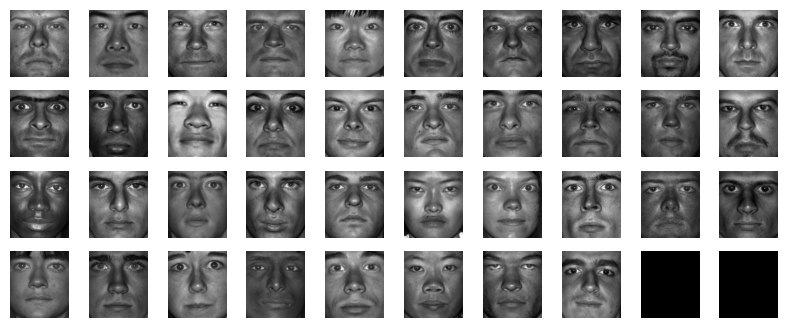

In [ ]:
cnt = 0
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
for i in range(n_persons):
    all_diff_persons[:,i] = X[:,cnt]
    cnt = cnt + y[i]

show_montage(all_diff_persons, n, m, 4,10)

## Step2 :  prepare for Torch
首先將影像以 8 : 2 分成訓練集與資料集，並將資料轉成可供 pyTorch 使用的 Torch，Dataset 定義了資料的結構跟資料本身。接著，DataLoader 定義了使用讀取資料的方式，batch_size 定義了每次執行一個 forward & backward pass 要使用的資料量，量的大小決定了每次學習的資料觀察量，也就是說會影響學習到的特徵，而 shuffle 則是決定了每個 epoch 進行時，batch 的排列順序會不會相同。

In [ ]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X.T, y_label, test_size= test_size) # deafult test_size=0.2
 
# prepare data for PyTorch Tensor
X_train = torch.from_numpy(X_train).float() # convert to float tensor
y_train = torch.from_numpy(y_train).float() # 
train_dataset = TensorDataset(X_train, y_train) # create your datset
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
test_dataset = TensorDataset(X_test, y_test) # create your datset
 
# create dataloader for PyTorch
batch_size = 64 # 32, 64, 128, 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # convert to dataloader
test_loader = DataLoader(test_dataset, batch_size=len(X_test), shuffle=False)

## Step3 :  Set up NN Model
設定神經網路
- 將原先為 168*192 的維度縮減至 512 維
- 利用 ReLU 激活函數，在較省時間的情況下避免過度配適(前兩點共組為一層隱藏層)
- 將 512 的維度縮減至 40 維

利用高維度投影至低維度的方式進行維度縮減，目的在於減少不相關並提取重要的特徵，使訓練過程可以更有效率。亦可在模型中設定池化層 (pooling layer)，池化的目的在於減少資料量並保留重要資訊，常用的 maxpooling() 是保留 2*2 影像中的最大值，原先的影像就可以縮減為原先的 $\frac{1}{4}$  。


最後，設定模型傳遞的方式，透過 forward 去進步每次的學習成果。

In [ ]:
# select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu" # run faster than cuda in some cases
print("Using {} device".format(device))
 
# Create a neural network
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(168*192, 512), # image length 168*192,  fully connected layer
            nn.ReLU(), # try to take ReLU out to see what happen
            # nn.Linear(512, 512), # second hidden layer
            # nn.ReLU(),
            nn.Linear(512, 40) # 10 classes,  fully connected layer
            # nn.Softmax()
        )
    # Specify how data will pass through this model
    def forward(self, x):
        # out = self.mlp(x) 
 
        # Apply softmax to x here~
        x = self.mlp(x)
        out = F.log_softmax(x, dim=1) # it’s faster and has better numerical propertie than softmax
        # out = F.softmax(x, dim=1)
        return out
 
 
# define model, optimizer, loss function
model = MLP().to(device) # start an instance
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # default lreaning rate=1e-3
loss_fun = nn.CrossEntropyLoss() # define loss function
 
print(model)

Using cuda device
MLP(
  (mlp): Sequential(
    (0): Linear(in_features=32256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=40, bias=True)
  )
)


## Step4 :  Start training
設定 50 個 epoch ，每個 epoch 執行 30 個 batch ，開始訓練，並將模型輸出儲存。

In [ ]:
epochs = 50 # Repeat the whole dataset epochs times
model.train() # Sets the module in training mode. The training model allow the parameters to be updated during backpropagation.
plot_acc=[]
plot_loss=[]
for epoch in range(epochs):
# for epoch in tqdm(range(epochs)):
    trainAcc = 0
    samples = 0
    losses = []

    for batch_num, input_data in enumerate(train_loader):
    # for batch_num, input_data in tqdm(enumerate(train_loader), total=len(train_loader)):
         
        x, y = input_data
        x = x.to(device).float()
        y = y.to(device)
 
        # perform training based on the backpropagation
        y_pre = model(x) # predict y
        loss = loss_fun(y_pre, y.long()) # the loss function nn.CrossEntropyLoss()
        losses.append(loss.item())
 
        optimizer.zero_grad() # Zeros the gradients accumulated from the previous batch/step of the model
        loss.backward() # Performs backpropagation and calculates the gradients
        optimizer.step() # Updates the weights in our neural network based on the results of backpropagation
         
        # Record the training accuracy for each batch
        trainAcc += (y_pre.argmax(dim=1) == y).sum().item() # comparison
        samples += y.size(0)
        if batch_num % 4 == 0:
            print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
    print('Epoch %d | Loss %6.2f | train accuracy %.4f' % (epoch, sum(losses)/len(losses), trainAcc/samples))
    plot_acc.append(trainAcc/samples)
    plot_loss.append(sum(losses)/len(losses))
 
print('Finished ... Loss %7.4f | train accuracy %.4f' % (sum(losses)/len(losses), trainAcc/samples))
torch.save(model.state_dict(), 'yale_model.pth')

	Epoch 0 | Batch 0 | Loss   3.66
	Epoch 0 | Batch 4 | Loss  16.03
	Epoch 0 | Batch 8 | Loss   9.04
	Epoch 0 | Batch 12 | Loss  10.81
	Epoch 0 | Batch 16 | Loss   8.00
	Epoch 0 | Batch 20 | Loss  12.20
	Epoch 0 | Batch 24 | Loss  10.16
	Epoch 0 | Batch 28 | Loss   5.43
Epoch 0 | Loss  10.53 | train accuracy 0.3646
	Epoch 1 | Batch 0 | Loss   3.13
	Epoch 1 | Batch 4 | Loss   6.45
	Epoch 1 | Batch 8 | Loss   4.02
	Epoch 1 | Batch 12 | Loss   4.59
	Epoch 1 | Batch 16 | Loss   0.99
	Epoch 1 | Batch 20 | Loss   1.40
	Epoch 1 | Batch 24 | Loss   1.70
	Epoch 1 | Batch 28 | Loss   2.93
Epoch 1 | Loss   2.99 | train accuracy 0.7396
	Epoch 2 | Batch 0 | Loss   0.40
	Epoch 2 | Batch 4 | Loss   2.11
	Epoch 2 | Batch 8 | Loss   0.52
	Epoch 2 | Batch 12 | Loss   0.47
	Epoch 2 | Batch 16 | Loss   1.43
	Epoch 2 | Batch 20 | Loss   0.76
	Epoch 2 | Batch 24 | Loss   1.31
	Epoch 2 | Batch 28 | Loss   0.69
Epoch 2 | Loss   1.15 | train accuracy 0.8677
	Epoch 3 | Batch 0 | Loss   0.27
	Epoch 3 | Batch 4 | L

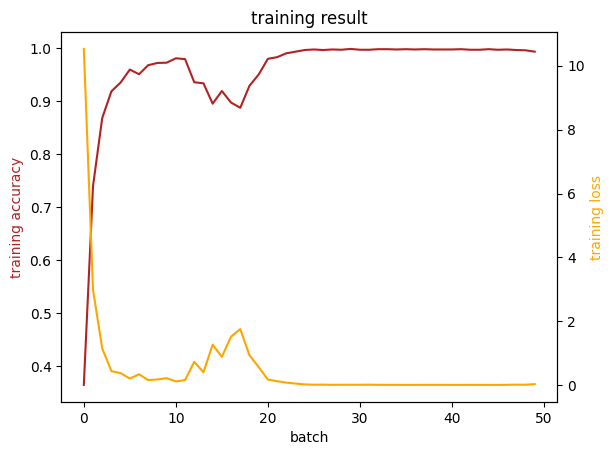

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(plot_acc,  c='firebrick')
ax1.set_xlabel('batch')
ax1.set_ylabel('training accuracy', c='firebrick')
ax2 = ax1.twinx()
ax2.plot(plot_loss, label='training loss', c='orange')
ax2.set_ylabel('training loss', c='orange')
plt.title('training result')
plt.show()

從訓練過程可以得到，training accuracy 會隨著 epoch　增加而逐漸上升, training loss 則是減少。

## Step5 :  Testing (1) : Compute test accuracy by batch
將訓練成果進行測試，並輸出測試的平均正確率。

In [ ]:
model.eval() 
testAcc = 0
samples = 0
with torch.no_grad():
    for x, y_truth in test_loader:
        x = x.to(device).float()
        y_truth = y_truth.to(device)
        y_pre = model(x).argmax(dim=1) # the predictions for the batch
        testAcc += (y_pre == y_truth).sum().item() # comparison
        samples += y_truth.size(0)
 
    print('Test Accuracy:{:.3f}'.format(testAcc/samples))

Test Accuracy:0.954


## Step6 : Testing (2): Compute the test accuracy and record the result for each test data
將訓練後的模型讀入並測試所有測試集內的人臉模型，儲存每張人臉的預測結果，並輸出測試的平均正確率。

In [ ]:
# use eval() in conjunction with a torch.no_grad() context, 
# meaning that gradient computation is turned off in evaluation mode
model = MLP().to(device)
model.load_state_dict(torch.load('yale_model.pth'))
model.eval() 
testAcc = 0
samples = 0


with open('mlp_att.csv', 'w') as f:
    fieldnames = ['ImageId', 'Label', 'Ground_Truth']
    writer = csv.DictWriter(f, fieldnames=fieldnames, lineterminator = '\n')
    writer.writeheader()
    image_id = 1
 
    with torch.no_grad():
        for x, y_truth in test_loader:
            x = x.to(device).float()
            y_truth = y_truth.to(device).long()
            yIdx = 0
            y_pre = model(x).argmax(dim=1) # the predictions for the batch
            testAcc += (y_pre == y_truth).sum().item() # comparison
            samples += y_truth.size(0)
            for y in y_pre:
                writer.writerow({fieldnames[0]: image_id,fieldnames[1]: y.item(), fieldnames[2]: y_truth[yIdx].item()})
                image_id += 1
                yIdx += 1
 
        print('Test Accuracy:{:.3f}'.format(testAcc/samples))

Test Accuracy:0.954


顯示分類後的表格

In [ ]:
acc_result=pd.read_csv('mlp_att.csv')
acc_result.head()

,ImageId,Label,Ground_Truth
0,1,17,17
1,2,29,29
2,3,23,23
3,4,18,18
4,5,2,2


## 資料分析
## - 神經網路(Convolutional Neural Network)

In [2]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import scipy
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import csv
import os
import cv2
from sklearn.metrics import confusion_matrix

## Step 1 : Load data and prepare for Torch

In [3]:
 
D = scipy.io.loadmat(r"Yale.mat")
X = D['faces'] # 32256 x 2410 and I change to N*p, each column represents an image
X = X-np.tile(X.mean(axis=1).reshape(-1, 1), X.shape[1])
y = np.ndarray.flatten(D['nfaces']) ## 每個人各有多少張
y_label=np.repeat(range(len(y)), y)
m = int(D['m']) # 168
n = int(D['n']) # 192  ##一張影像的維度
n_persons = int(D['person']) # 38
all_diff_persons = np.zeros((m*n, n_persons))

 
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X.T, y_label, test_size=test_size)
 
X_train=X_train.reshape((-1 , 1, 192, 168), order='F')
X_test=X_test.reshape((-1, 1,  192, 168), order='F')
 
# convert to tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
# X_train = X_train.reshape(-1, 1, 192, 168) # convert to N x 1 x 28 x 28 for CNN
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()
# X_test = X_test.reshape(-1, 1, 192, 168) # N x 1 x 28 x 28
 
# check shapes of data
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)
 
# create dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train.shape: torch.Size([1928, 1, 192, 168])
y_train.shape: torch.Size([1928])
X_test.shape: torch.Size([482, 1, 192, 168])
y_test.shape: torch.Size([482])


## Step2 :  Set up CNN Model
介紹作品內所特別設定的 conv2d 參數
- in_channels (int) – 輸入影像的通道數
- out_channels (int) – 決定影像經過捲積之後會產生出多少通道
- kernel_size (int or tuple) – 決定 kernel 的大小
- stride (int or tuple, optional) – 決定捲積的移動距離
- padding (int, tuple or str, optional) – 決定將原先影像周遭填充多少 0 (0 是預設，亦可透過 padding_mode 參數去調整)

開始設定模型

藉由兩次捲積，激活，池化的過程，增加特徵，學習特徵來訓練出模型。而 $45*39*16$ 的由來是原本 $192*168$ 的影像檔案，在單一維度中，因為 $kernel = 5*5，padding = 0$的設定，所以在捲積的過程中會損失 4 ，經過$(2, 2)$的最大池化後，資料會變原先的一半 ，故經過兩次後 $\frac{\frac{192-4}{2}-4}{2}=45$，$\frac{\frac{168-4}{2}-4}{2}=39$，而 16 是最後設定出的 output_channel。nn.Linear($45*39*4$, 38) 的 38 則是類別的個數。

In [13]:
class Net(nn.Module):
 
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5) # 1 input channel, 6 output channels, 5x5 square convolution
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channel, 16 output channels, 5x5 square convolution
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(45*39*16, 45*39*2)  # 4*4 from image dimension 
        self.fc2 = nn.Linear(45*39*2, 38)
 
    def forward(self, x):

        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # Max pooling over a (2, 2) window
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
 
 
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
 
net = Net().to(device)
print(net)

Using cuda:0 device
Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28080, out_features=3510, bias=True)
  (fc2): Linear(in_features=3510, out_features=38, bias=True)
)


## Step3 Set up Loss function and optimizer
Adam 會比 SGD 耗更多資源，但速度比較快

In [14]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.0001) 

## Step4 Train the network
觀察 loss 是否有隨著 epoch　增加而減少

In [15]:
epochs = 30
for epoch in range(epochs):  # loop over the dataset multiple times
 
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device) # move to GPU if available
     
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs) # forward pass
        loss = criterion(outputs, labels) # compute loss
        # writer.add_scalar("Loss/train", loss, epoch)
        loss.backward() # compute gradients
        optimizer.step() # update weights
 
        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 200 mini-batches
            print(f'[epoch : {epoch + 1}, batch: {i + 1:5d}] loss: {running_loss / 30:.3f}')
            running_loss = 0.0
 
print('Finished Training')

[epoch : 1, batch:    30] loss: 12.904
[epoch : 2, batch:    30] loss: 0.903
[epoch : 3, batch:    30] loss: 0.177
[epoch : 4, batch:    30] loss: 0.086
[epoch : 5, batch:    30] loss: 0.059
[epoch : 6, batch:    30] loss: 0.047
[epoch : 7, batch:    30] loss: 0.039
[epoch : 8, batch:    30] loss: 0.035
[epoch : 9, batch:    30] loss: 0.031
[epoch : 10, batch:    30] loss: 0.028
[epoch : 11, batch:    30] loss: 0.025
[epoch : 12, batch:    30] loss: 0.024
[epoch : 13, batch:    30] loss: 0.022
[epoch : 14, batch:    30] loss: 0.021
[epoch : 15, batch:    30] loss: 0.019
[epoch : 16, batch:    30] loss: 0.019
[epoch : 17, batch:    30] loss: 0.017
[epoch : 18, batch:    30] loss: 0.016
[epoch : 19, batch:    30] loss: 0.015
[epoch : 20, batch:    30] loss: 0.015
[epoch : 21, batch:    30] loss: 0.014
[epoch : 22, batch:    30] loss: 0.013
[epoch : 23, batch:    30] loss: 0.013
[epoch : 24, batch:    30] loss: 0.014
[epoch : 25, batch:    30] loss: 0.012
[epoch : 26, batch:    30] loss: 

In [16]:
PATH = './yale_cnn_model.pth' # .pth will collide with the PyTorch JIT
torch.save(net.state_dict(), PATH)

## Step4(1) Evaluate the model on test data
將測試集內的 482 筆資料分成 8 份進行測試， 並算預測的平均準確率

In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print(f'Accuracy of the network on the 482 test images: {100 * correct // total} %')

Accuracy of the network on the 482 test images: 95 %


## Step4(2) Test on a random batch
因為先前將 batch size 設為 64，故現在隨機抽取測試及內的一組來進行測試，印出影像、預測標籤，最後算出 64 張影像的平均正確率。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


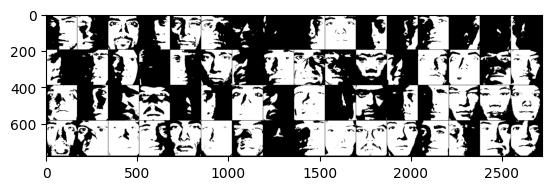

The predictions:
 {tensor([[36,  2,  8, 34, 33, 28, 30, 32,  5, 15, 29, 18, 16, 25, 33, 24],
        [17, 18, 26, 18, 29, 11,  3, 34,  7, 36, 35,  4,  6,  5,  3, 25],
        [ 6, 32,  2, 19, 26, 29, 13, 16, 12,  7,  8, 28,  9, 36, 35, 26],
        [11, 29,  2, 15, 16,  2, 36,  3, 34, 25, 19, 22, 37,  6,  1, 30]],
       device='cuda:0')}
Accuracy of the network on the 64 test images: 96.875 %


In [19]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
 
sample_idx = torch.randint(len(test_loader), size=(1,)).item()
dataiter = iter(test_loader)
for i in range(sample_idx): # randomly select a batch
    images, labels = next(dataiter)
 
# print test images
nrow = 16 # number of images per row
montage = torchvision.utils.make_grid(images, nrow=nrow)
plt.imshow(np.transpose(montage, (1, 2, 0)), cmap='gray')
plt.show()
 
# predict the labels
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
print("The predictions:\n", {predicted.reshape(batch_size // nrow, nrow)})
 
total = labels.size(0)
correct_rate = (predicted == labels.to(device)).sum().item() / total
print(f'Accuracy of the network on the 64 test images: {100 * correct_rate} %')

## 讀入上方訓練模型，隨機輸入一個人臉，並判斷出標籤

ground truth = 20, predict=20


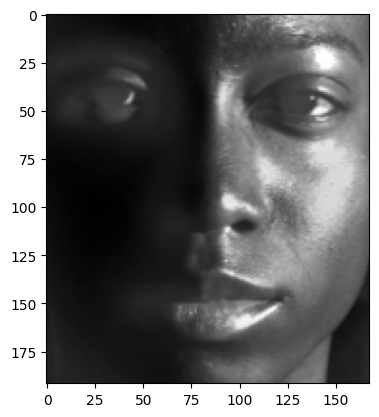

In [22]:
model  = Net().to(device)
model.load_state_dict(torch.load('../yale/yale_cnn_model.pth'))
for i in range(1):
 sample_idx = torch.randint(len(y_label), size=(1,)).item()
 X_r=X.T.reshape((-1 , 1, 192, 168), order='F')[sample_idx]
 X_r=X_r.reshape(192, 168)
 plt.imshow(X_r, cmap='gray')
 X_r=X_r.reshape(1 , 1, 192, 168)
 X_r=torch.from_numpy(X_r).float()
 outputs=net(X_r.to(device))
 _, predicted=torch.max(outputs.data ,1)
 print('ground truth = {}, predict={}'.format(y_label[sample_idx], predicted.item()))

# NN 與 CNN 比較
- 從兩種結果可以看，使用 NN 便可以在預測時達到好效果，所以不一定需要使用 CNN 來增加訓練的時間與 GPU 的效能。